In [1]:
%pip install torch torchvision transformers diffusers datasets accelerate
# !unzip dataset.zip

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

C:\Users\tomma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Sequential(torch.nn.Linear(768, 1),
                                                    # torch.nn.Sigmoid())
                                                    torch.nn.Tanh())


teacher_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)

student_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading pipeline components...:  57%|█████▋    | 4/7 [00:00<00:00,  7.17it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...:  43%|████▎     | 3/7 [00:01<00:01,  2.59it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overr

In [5]:
# Move models to the chosen device

# discriminator_model = discriminator_model.to(device)
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)
print(discriminator_model)


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [6]:
# Set up the loss functions for the student model

# Hinge loss for adversarial loss
adversarial_loss_function = torch.nn.HingeEmbeddingLoss()
adversarial_loss_function.requires_gradient = True

# MSE loss for distillation loss
distillation_loss_function = torch.nn.MSELoss()
distillation_loss_function.requires_gradient = True

# Set up the optimizer for the student model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.0001)

# Assuming you have a discriminator model defined
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0001)

In [7]:
# load the train dataset from folder dataset/captions_train2017.json
dataset = load_dataset('json', data_files='dataset/dataset.json')

train_dataset = dataset["train"]

#split the dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
validation_dataset = dataset["test"]

#further split the train dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)

torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)


Dataset({
    features: ['caption', 'image'],
    num_rows: 239659
})
Dataset({
    features: ['caption', 'image'],
    num_rows: 29588
})
Dataset({
    features: ['caption', 'image'],
    num_rows: 26629
})


In [8]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)

def to_label(pred):

  if pred < 0.5:
    return torch.tensor(-1.0)

  else:
    return torch.tensor(1.0)



torch.Size([3, 256, 256])


In [9]:
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

Epoch 0, Batch Caption: A dark room has an alarm clock on a table.


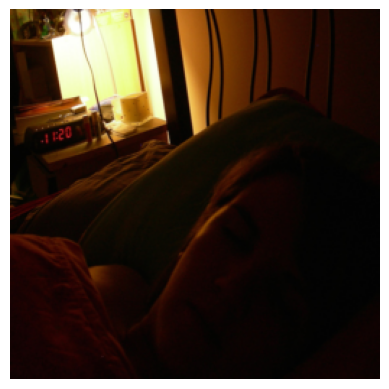

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


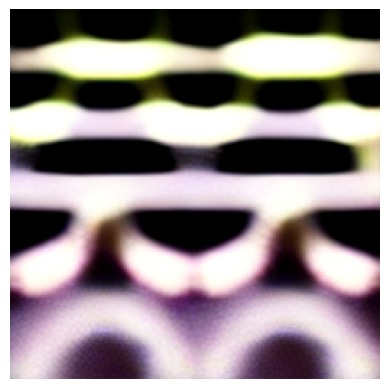

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


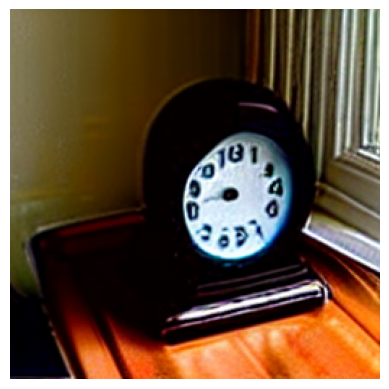

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Adversarial Loss: -0.09928372502326965
Distillation Loss: 0.3232038915157318
End of batch processing.

Epoch 0, Batch Caption: a group of various motorcycles parking in a line 


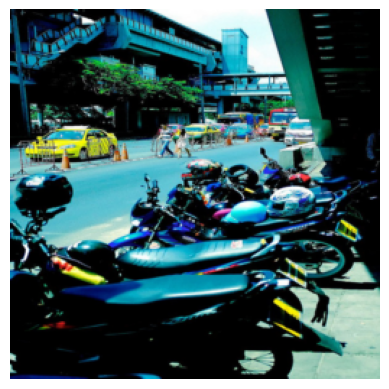

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


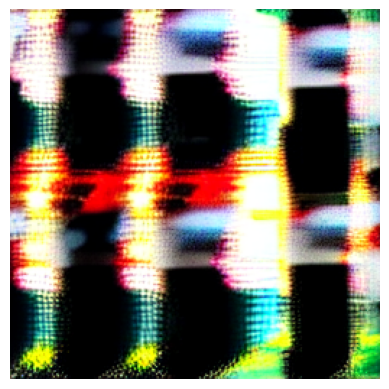

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


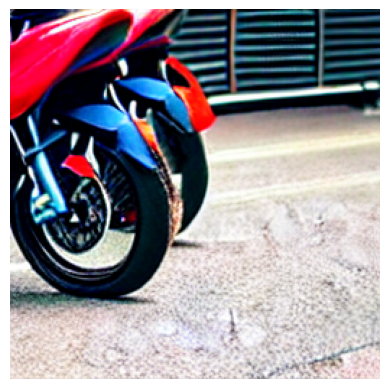

Adversarial Loss: -1.0
Distillation Loss: 0.35419678688049316
End of batch processing.

Epoch 0, Batch Caption: A horse standing in an enclosed area with another directly behind it.


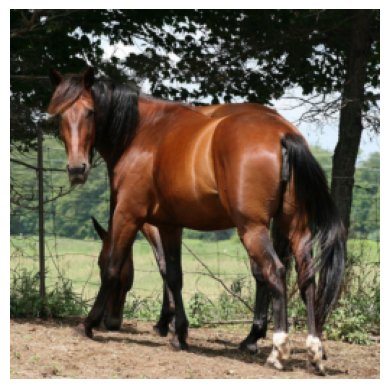

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


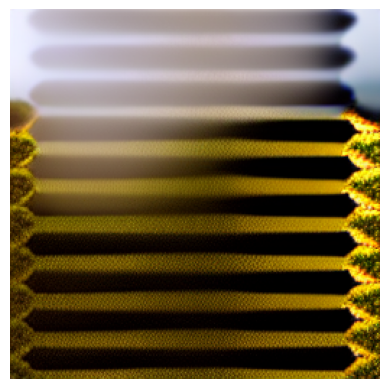

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


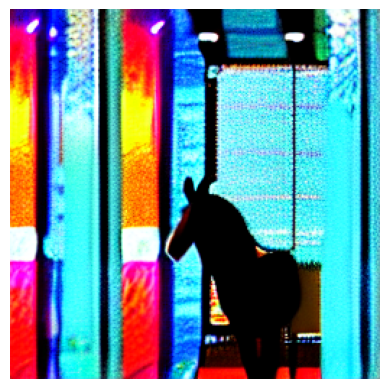

Adversarial Loss: -1.0
Distillation Loss: 0.28211691975593567
End of batch processing.

Epoch 0, Batch Caption:  a person wearing a backpack and pulling a rolling suitcase behind them while walking on a sidewalk.


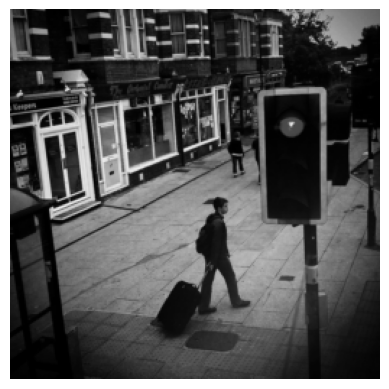

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:00<00:00,  8.09it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


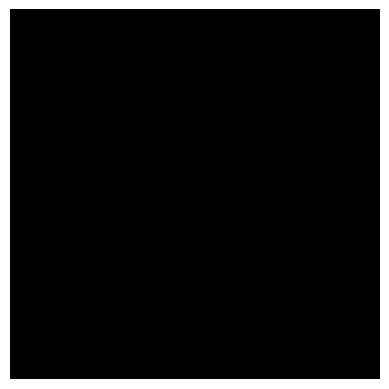

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


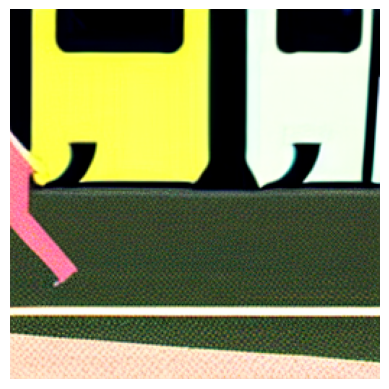

Adversarial Loss: -1.0
Distillation Loss: 0.35631677508354187
End of batch processing.

Epoch 0, Batch Caption: There is a picture of an outside area.



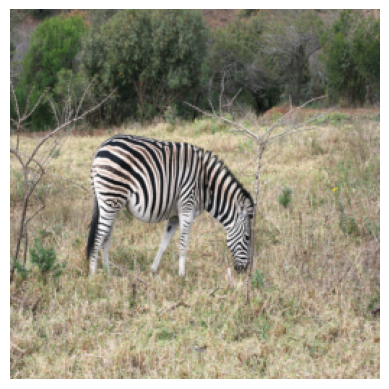

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


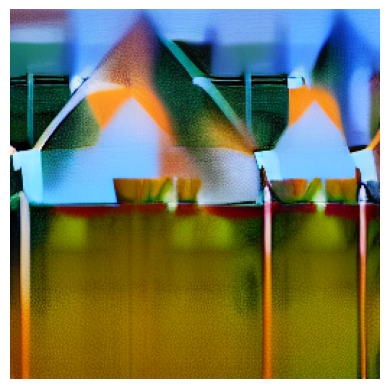

Forward diffusion on student image...
Generating teacher image...


 20%|██        | 5/25 [00:00<00:03,  6.44it/s]


KeyboardInterrupt: 

In [11]:
for epoch in range(100):
    for batch in train_dataset:

        image = url_to_tensor(batch["image"])
        caption = batch["caption"]

        # Creating labels for real and fake images
        valid = torch.ones(image.size(0), 1)
        fake = torch.zeros(image.size(0), 1)
        real_image = image

        # Displaying the base image and its caption
        print(f"Epoch {epoch}, Batch Caption: {caption}")
        show_tensor_image(real_image)

        # Forward diffusion step
        print("Performing forward diffusion...")
        diffused_image = forward_noise(image, a=0.5, s=0.5, num_diffusion_steps=50)

        # Transforming images for distillation loss calculation
        transform = transforms.ToTensor()

        # Generating student image
        print("Generating student image...")
        student_image = student_model(caption, image=diffused_image, height=256, width=256, num_inference_steps=4).images[0]
        student_image_tensor = transform(student_image)
        show_tensor_image(student_image_tensor)

        # Forward diffusion on student image
        print("Forward diffusion on student image...")
        new_diffused_image = forward_noise(student_image, a=0.5, s=0.5, num_diffusion_steps=50)

        # Generating teacher image
        print("Generating teacher image...")
        teacher_image = teacher_model(caption, image=new_diffused_image, height=256, width=256, num_inference_steps=25).images[0]
        teacher_image_tensor = transform(teacher_image)
        show_tensor_image(teacher_image_tensor)

        # Discriminator predictions and loss for real image
        real_pred = discriminator_processor(image, return_tensors="pt")
        real_pred = discriminator_model(**real_pred).logits
        real_loss = adversarial_loss_function(real_pred, torch.tensor(1.))

        # Discriminator predictions and loss for student image
        student_pred = discriminator_processor(student_image, return_tensors="pt")
        student_pred = discriminator_model(**student_pred).logits
        student_loss = adversarial_loss_function(student_pred, torch.tensor(1.))

        # Calculating adversarial loss
        adversarial_loss = (real_loss + student_loss) / 2
        print(f"Adversarial Loss: {adversarial_loss}")

        # Computing distillation loss
        distillation_loss = distillation_loss_function(student_image_tensor, teacher_image_tensor)
        distillation_loss.requires_grad = True
        print(f"Distillation Loss: {distillation_loss}")

        # Backpropagation for student model
        student_optimizer.zero_grad()
        student_loss.backward(retain_graph=True) # Retain graph because student model also needs to backpropagate in this iteration
        distillation_loss.backward()
        student_optimizer.step()

        # Backpropagation for discriminator model
        discriminator_model_optimizer.zero_grad()
        adversarial_loss.backward()  
        discriminator_model_optimizer.step()

        print("End of batch processing.\n")
